In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from adjustText import adjust_text

In [39]:
df = pd.read_csv('filmes_filtrados.csv')

In [40]:
# Convert the 'genres' column to a list of genres
df['genre_names'] = df['genres'].apply(lambda x: x.split())

In [41]:
#display(df[["id", "title", "genre_names"]])

In [42]:
# Explode os gêneros para análises individuais
df_exploded = df.explode('genre_names')

In [43]:
#display(df_exploded.head())

In [44]:
# Calcula a média das notas por gênero
media_por_genero = df_exploded.groupby('genre_names')['vote_average'].mean()

C:\Users\iahuu\AppData\Local\Temp\ipykernel_15200\930335665.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media.values, y=media.index, palette=colors)


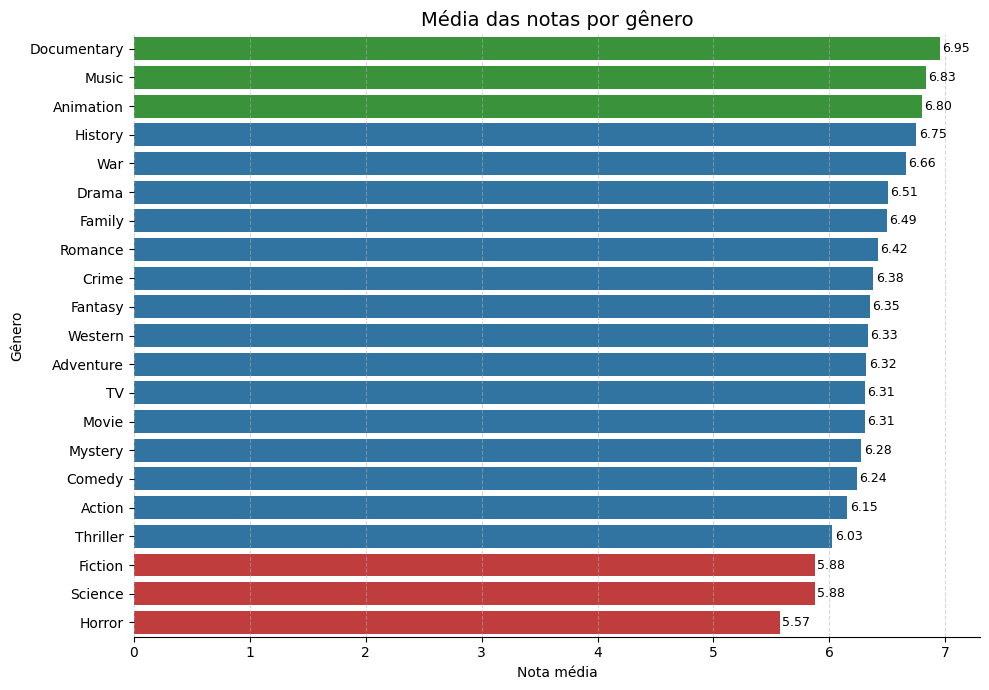

In [45]:
# Ordenar do maior para o menor
media = media_por_genero.sort_values(ascending=False)

# Top 3 e bottom 3 (com base na ordem original)
top_3 = media.head(3).index
bottom_3 = media.tail(3).index

# Lista de cores
colors = [
    '#2ca02c' if g in top_3 else '#d62728' if g in bottom_3 else '#1f77b4'
    for g in media.index
]

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(x=media.values, y=media.index, palette=colors)

# Adiciona as notas ao lado das barras
for i, v in enumerate(media.values):
    plt.text(v + 0.02, i, f"{v:.2f}", va="center", fontsize=9)

# Estética
plt.title('Média das notas por gênero', fontsize=14)
plt.xlabel('Nota média')
plt.ylabel('Gênero')
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=False)
plt.tight_layout()
plt.show()


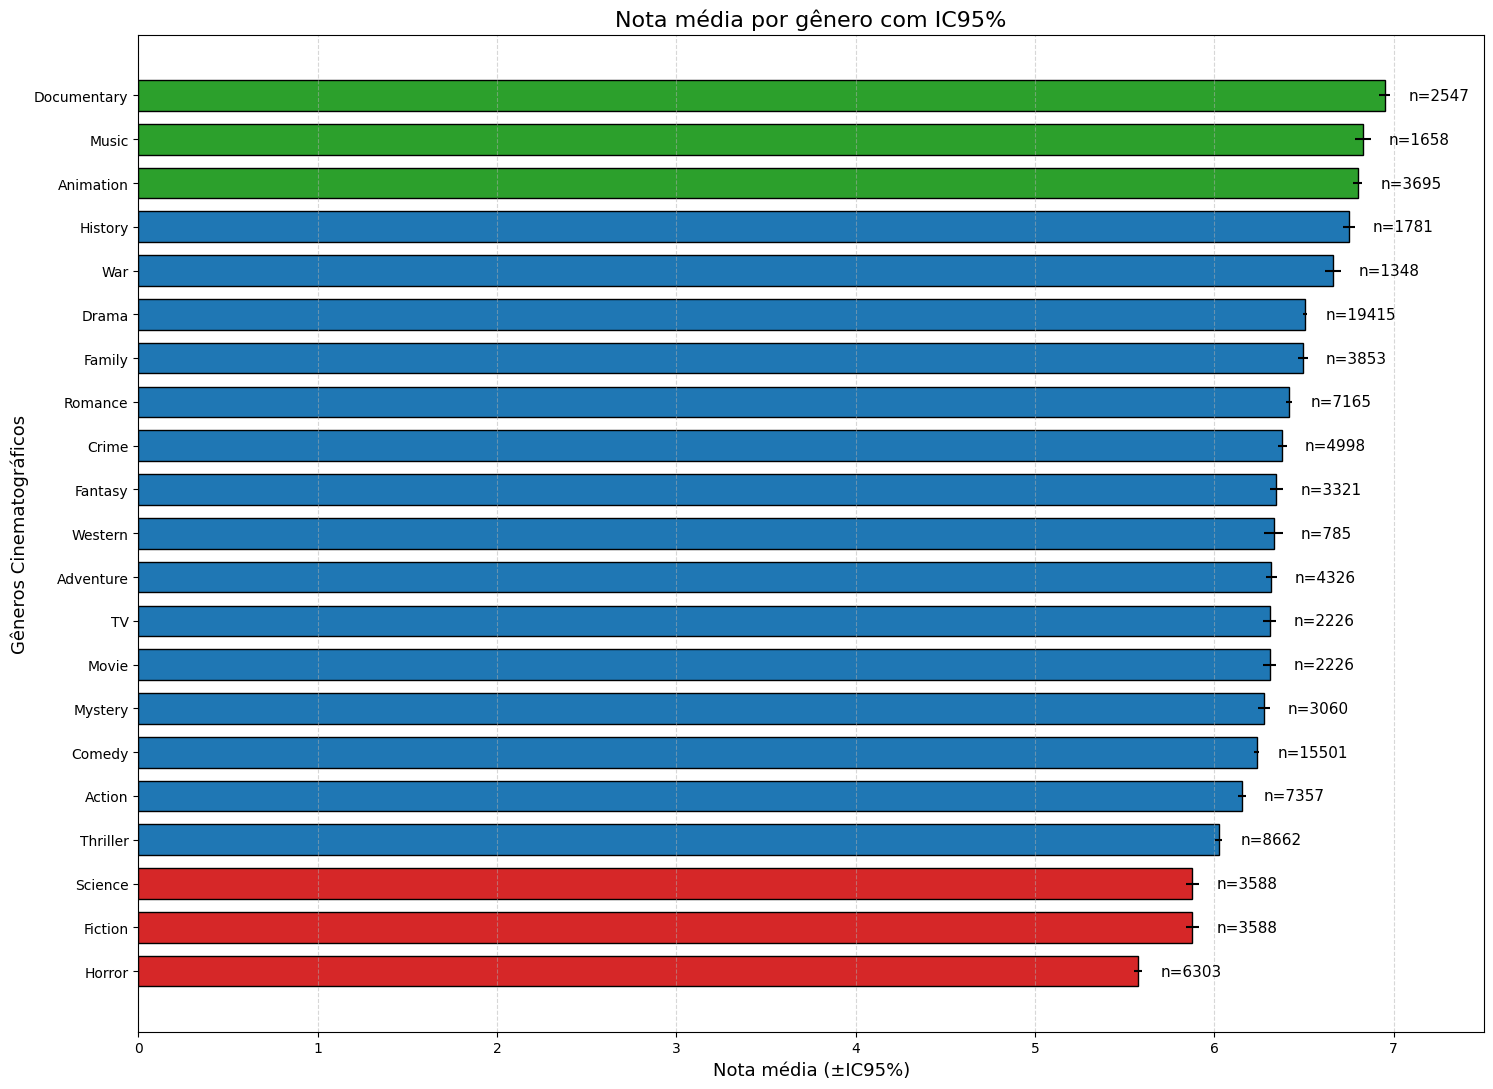

In [46]:
# Calcular médias, contagens e erro padrão por gênero
means = df_exploded.groupby('genre_names')['vote_average'].mean()
counts = df_exploded.groupby('genre_names')['vote_average'].count()
stds = df_exploded.groupby('genre_names')['vote_average'].std()
errs = (stds / counts.pow(0.5)) * 1.96  # IC 95%

# Ordenar por média crescente (de baixo para cima)
means = means.sort_values(ascending=True)

# Redefinir as cores: vermelho para bottom 3 (agora em cima), verde para top 3 (agora embaixo)
colors = [
    '#d62728' if g in bottom_3 else '#2ca02c' if g in top_3 else '#1f77b4'
    for g in means.index
]
errs = errs[means.index]
counts = counts[means.index]

# Usar a lista de cores já definida para destacar top 3 e bottom 3
plt.figure(figsize=(16, 11))
bars = plt.barh(means.index, means.values, xerr=errs.values, color=colors, edgecolor='k', height=0.7)

# Ajuste do deslocamento e limite do eixo x
max_mean = means.values.max()
max_err = errs.values.max()
plt.xlim(right=max_mean + max_err + 0.5)  # margem extra

for i, (mean, count, err) in enumerate(zip(means.values, counts.values, errs.values)):
    plt.text(mean + err + 0.1, i, f"n={count}", va='center', fontsize=11)

plt.xlabel('Nota média (±IC95%)', fontsize=13)
plt.ylabel('Gêneros Cinematográficos', fontsize=13)
plt.title('Nota média por gênero com IC95%', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout(rect=[0, 0, 0.94, 1])
plt.show()

7 [0.90340805 0.15340418]
8 [-0.2212348 -0.5813757]


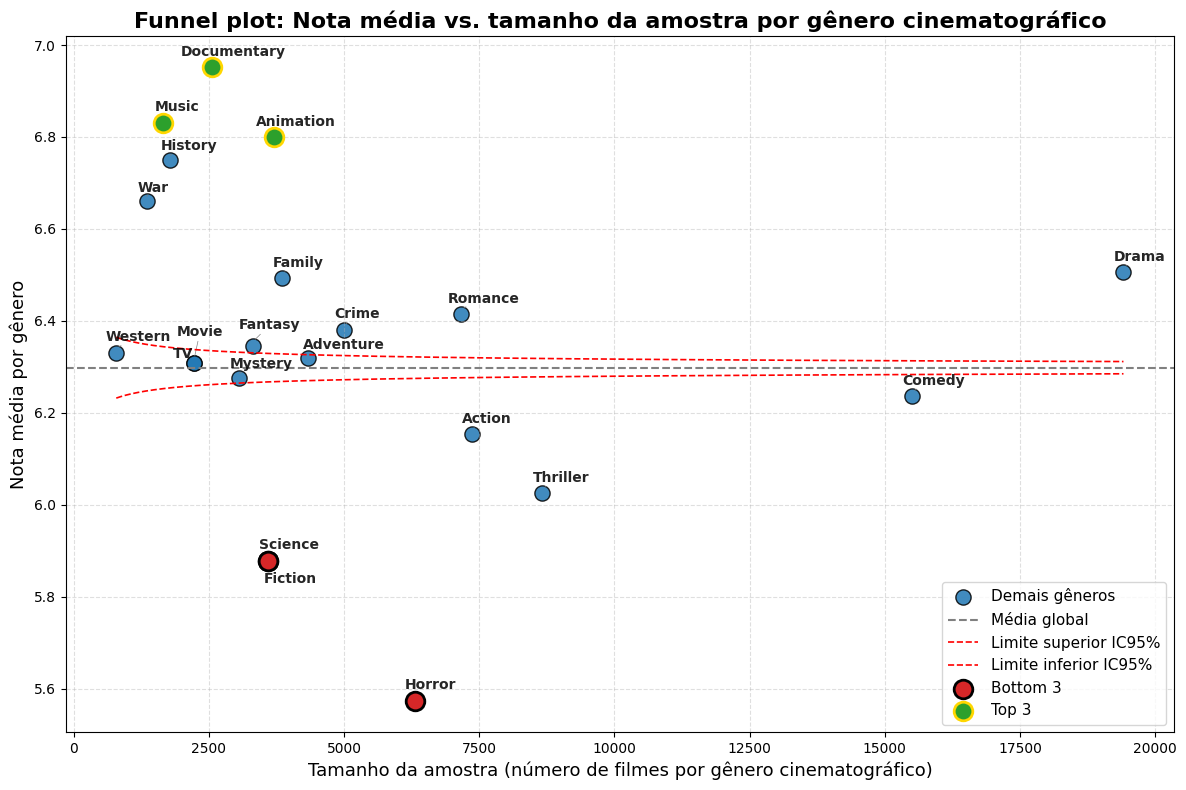

In [47]:
# media_global: média global das notas dos filmes
media_global = df_exploded['vote_average'].mean()

# n_range: intervalo de tamanhos de amostra (número de filmes por gênero)
n_range = np.arange(counts.min(), counts.max() + 1)

# upper e lower: limites superior e inferior do IC95% para a média global
sem_global = df_exploded['vote_average'].std() / np.sqrt(n_range)
ic95 = 1.96 * sem_global
upper = media_global + ic95
lower = media_global - ic95

plt.figure(figsize=(12, 8))
# Corrige a cor dos "Demais gêneros" para azul padrão
plt.scatter(counts.values, means.values, c='#1f77b4', s=120, edgecolor='k', alpha=0.85, label='Demais gêneros')

# Cria uma lista de objetos de texto para ajustar depois
texts = []
for x, y, label in zip(counts.values, means.values, means.index):
    # Ajusta a posição do texto para "Fiction" para evitar sobreposição
    if label == "Fiction":
        texts.append(plt.text(x, y - 0.02, label, fontsize=10, va='top', ha='center', alpha=0.85, fontweight='bold'))
    else:
        texts.append(plt.text(x, y+0.01, label, fontsize=10, va='bottom', ha='center', alpha=0.85, fontweight='bold'))

plt.axhline(media_global, color='gray', linestyle='--', linewidth=1.5, label='Média global')
plt.plot(n_range, upper, color='red', linestyle='--', linewidth=1.2, label='Limite superior IC95%')
plt.plot(n_range, lower, color='red', linestyle='--', linewidth=1.2, label='Limite inferior IC95%')

# Destaque top 3 e bottom 3 com legendas específicas
for genre, x, y in zip(means.index, counts.values, means.values):
    if genre in top_3:
        plt.scatter(x, y, color='#2ca02c', s=180, edgecolor='gold', linewidth=2, zorder=5, label='Top 3' if genre == top_3[0] else "")
    elif genre in bottom_3:
        plt.scatter(x, y, color='#d62728', s=180, edgecolor='black', linewidth=2, zorder=5, label='Bottom 3' if genre == bottom_3[0] else "")

plt.xlabel('Tamanho da amostra (número de filmes por gênero cinematográfico)', fontsize=13)
plt.ylabel('Nota média por gênero', fontsize=13)
plt.title('Funnel plot: Nota média vs. tamanho da amostra por gênero cinematográfico', fontsize=16, fontweight='bold')

# Ajusta a legenda para não repetir itens
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='lower right', fontsize=11)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

# Ajusta os textos para evitar sobreposição
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

plt.show()


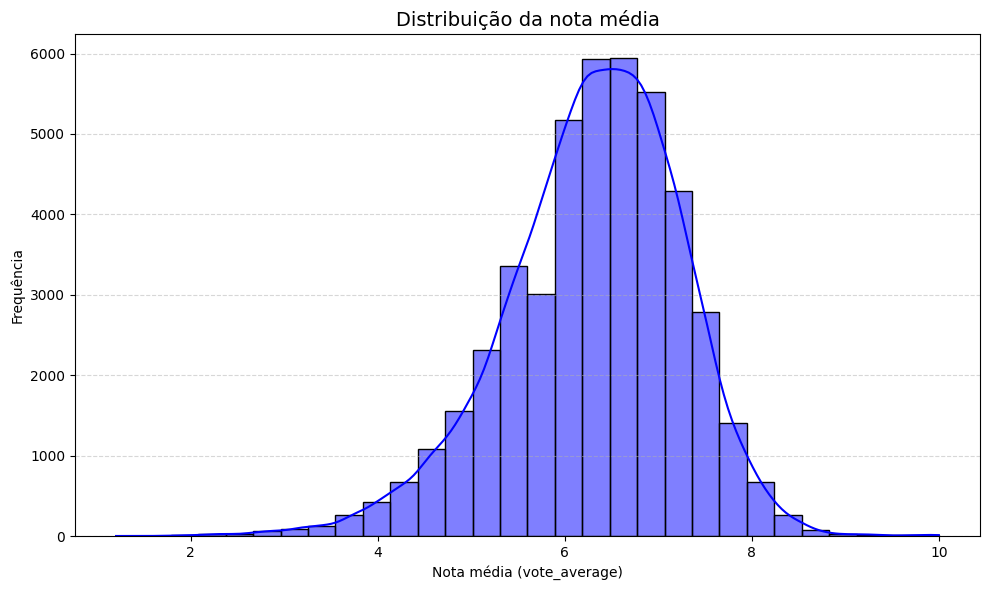

Estatística do teste: 0.9844, p-valor: 0.0000
As notas dos filmes não seguem uma distribuição normal (rejeitamos H0).


c:\Users\iahuu\Documents\GitHub\projeto-pisi3\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 45142.
  res = hypotest_fun_out(*samples, **kwds)


In [48]:
# Histograma e gráfico de densidade
plt.figure(figsize=(10, 6))
sns.histplot(df['vote_average'], kde=True, bins=30, color='blue')
plt.title('Distribuição da nota média', fontsize=14)
plt.xlabel('Nota média (vote_average)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Teste de normalidade Shapiro-Wilk
stat, p = shapiro(df['vote_average'])
print(f"Estatística do teste: {stat:.4f}, p-valor: {p:.4f}")

# Interpretação do p-valor
if p > 0.05:
    print("As notas dos filmes seguem uma distribuição normal (não rejeitamos H0).")
else:
    print("As notas dos filmes não seguem uma distribuição normal (rejeitamos H0).")

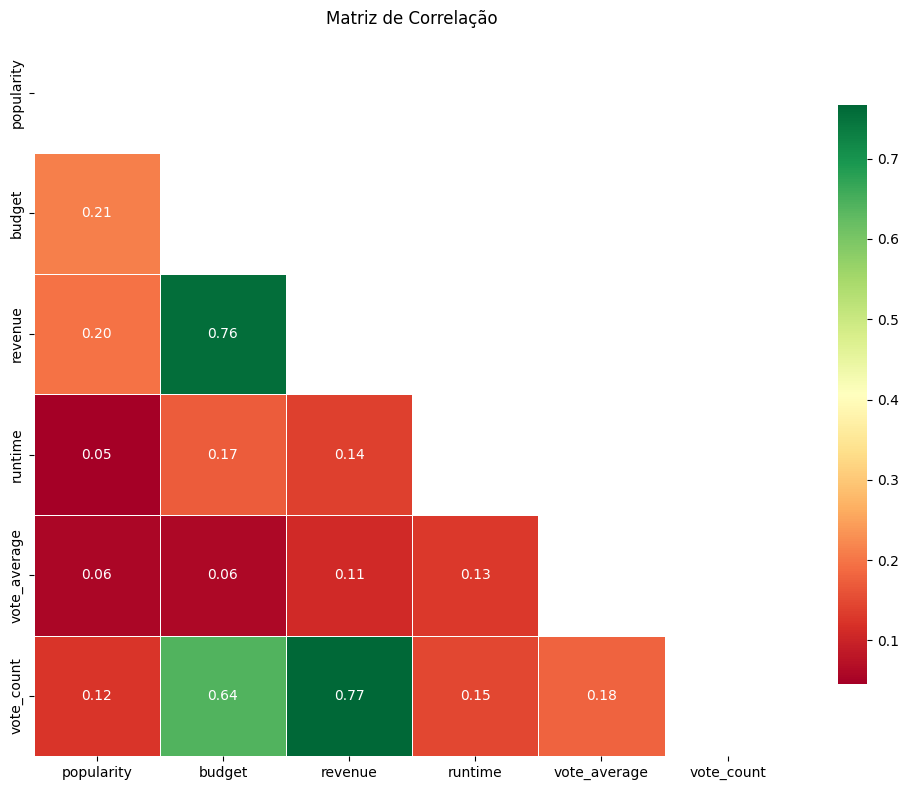

In [49]:
# Calcula a correlação
# Remove colunas indesejadas como 'index' e 'id', se existirem
df_corr = df.drop(columns=['index', 'id'], errors='ignore')

# Calcula a matriz de correlação apenas com colunas numéricas
correlacao = df_corr.corr(numeric_only=True)
# Cria a máscara para a parte superior
mask = np.triu(np.ones_like(correlacao, dtype=bool))

# Tamanho da figura
plt.figure(figsize=(10, 8))

# Heatmap
sns.heatmap(
    correlacao,
    mask=mask,
    cmap='RdYlGn',  # Mapa de cores vermelho → amarelo → verde
    annot=True,
    fmt=".2f",
    linewidths=.5,
    cbar_kws={"shrink": .8}
)

plt.title("Matriz de Correlação")
plt.tight_layout()
plt.show()